In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# load modules related to this exercise
import simple_zurcher as model

In [2]:
# Create a function that plots the value and policy functions
def plot_solution(par, sol):
    # make a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(par.grid, sol.V)
    ax[0].set_title('Value function')
    ax[0].set_xlabel('milage')
    
    ax[1].plot(par.grid, sol.pk)
    ax[1].set_title('Probability of keeping')
    ax[1].set_xlabel('milage')
    ax[1].yaxis.set_major_formatter('{x:.0%}')

## Exercise 1 - Deterministic state transition

Consider the engine replacement model given by:

$$
V(x) = \max_{d\in \{0,1\}} \big\{ u(x,d) + \beta V(x') \big\} \\
$$

Where the state transition is deterministically given by:
$$
x'=\left \{
\begin{array}{ll}
    x + 1 & \text{if }d=\text{keep}=0 \\
    1 & \text{if }d=\text{replace}=1
\end{array} \right.
$$

utility is given by:

$$
u(x,d)=\left \{
\begin{array}{ll}
    -c(x) & \text{if }d=\text{keep}=0 \\
    -RC-c(0) & \text{if }d=\text{replace}=1
\end{array} \right.
$$

Here

- $ x $ = milage of the engine
- $ RC $ = replacement cost  
- $ c(x) = c \cdot x $ = cost of maintenance




##### a) Orient yourself with the objects in the function *setup*, *solve_VFI*, *bellman*, *util*, and *cost* in *simple_zurcher.py*.

##### b) Fill in the missing stuff in the *bellman* and *EV_deterministic* functions. Solve the model. Plot the solution.
In the *bellman* function, you don't have to fill in code for *taste_shocks* other than for *taste_shocks == 'None'*.

In [3]:
par = model.setup()
sol = model.solve_SA(par)

Finished after 1736 iterations
Convergence achieved: True


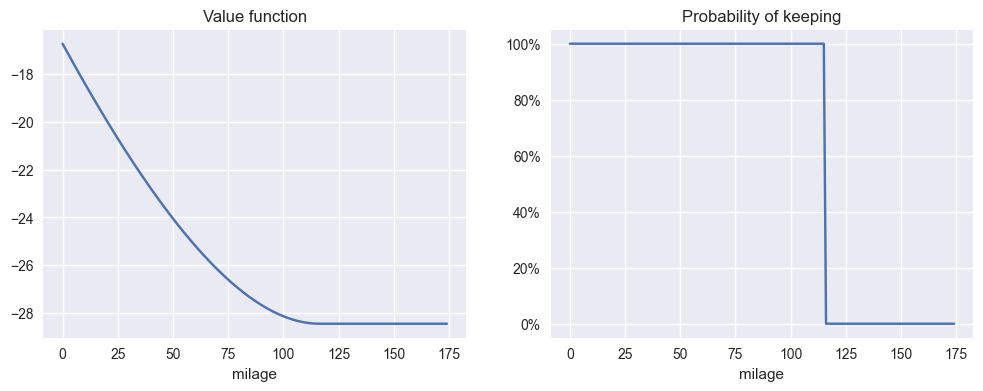

In [4]:
plot_solution(par, sol)

In [5]:
value_keep = -par.cost_grid + par.beta * par.P1 @ sol.V # nx1 matrix
value_replace = -par.RC - par.cost_grid[0] + par.beta * par.P2@ sol.V # nx1 matrix

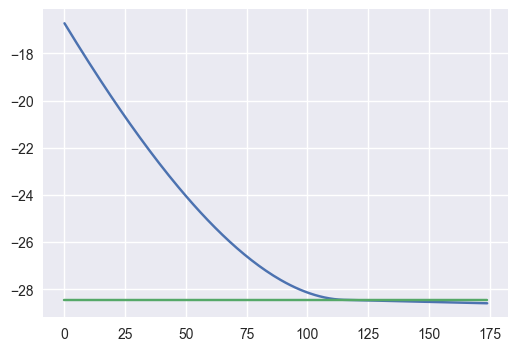

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(par.grid, value_keep, label='Keep')
ax.plot(par.grid, value_replace, label='Replace')


##### c) When is it optimal to replace the engine?

## Exercise 2 - Stochastic state transition

Now we change the assumption of a deterministic state transition to a stochastic one. The state transition is now given by:
$$
x'=\left \{
\begin{array}{ll}
    x + m & \text{if }d=\text{keep}=0 \\
    m & \text{if }d=\text{replace}=1
\end{array} \right.
$$

with $ m $ being a random variable that characterizes how many points we move in the grid (e.g. move 2 grid points from point 17 to 19). 

Mileage is generally a continuous variable. As in Rust (1997), we will discretize the mileage process such that m is discrete. 
Concretely, we assume that m can take on the values $ \{0,1,2\} $ with equal probability given by *$\pi( )$*.

The value function is now given by:
$$
V(x,\varepsilon) = \max_{d\in \{0,1\}} \big\{ u(x,d) + \beta
\underbrace{\sum_{X} V(x') \pi(x'|x,d)}_{EV(x,d)} \big\}
$$
In the lecture slides, Bertel writes this as an integral:
$$
V(x,\varepsilon) = \max_{d\in \{0,1\}} \big\{ u(x,d) + \beta
\underbrace{\int_{X} V(x') \pi(x'|x,d)}_{EV(x,d)} dx' \big\}
$$



##### a) Fill in the missing stuff in the *EV_stochastic* function. Solve the model. Plot the solution.

In [7]:
sol = model.solve_SA(par, stochastic_transition = True)

Finished after 1710 iterations
Convergence achieved: True


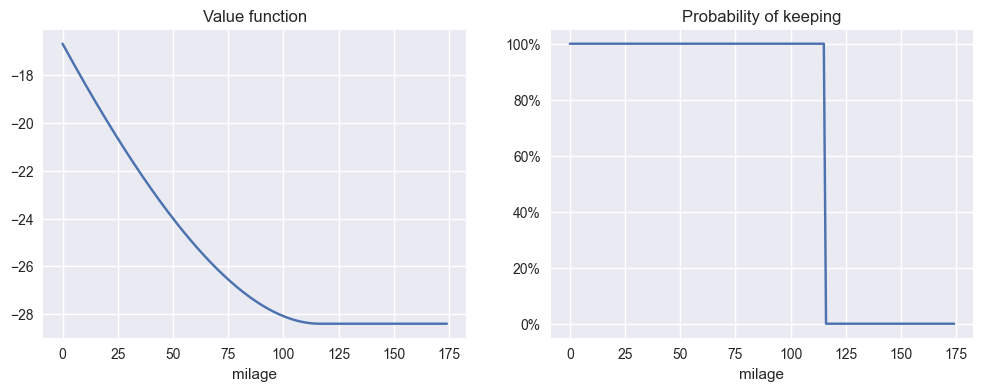

In [8]:
plot_solution(par, sol)

##### b) When is it now optimal to replace the engine? Is it different from before? Why, why not?
*Hint*: Are agents risk-averse?

## Exercise 3 - Taste shocks (Monte Carlo Extreme value)

Now we change the assumption of observing all relevant characteristics. We assume that there are some states unobserved to the econometrician. In particular, we assume that there is a taste shock $ \varepsilon $ for each choice that is unobserved to the econometrician and additively separable in the utility. 

We will assume that $ \varepsilon $ is distributed according to the extreme value distribution type 1 given by the pdf *q( )*, is conditionally independant from x, and has bound $\Omega$. We can write the value function as

$$
V(x,\varepsilon) = \max_{d\in \{0,1\}} \big\{ u(x,d) + \varepsilon_d + \beta
\underbrace{\sum_{X} \int_{\Omega} V(x',\varepsilon') \pi(x'|x,d) q(\varepsilon'|x')  d\varepsilon' }_{EV(x,d)} \big\}
$$

Because of the taste shock today, choices are now stochastic. And also, we now have to handle the expectation of these taste shocks tommorow, which we can do by integrating them out.


In the lecture slides, this is written as a double-integral:
$$
V(x,\varepsilon) = \max_{d\in \{0,1\}} \big\{ u(x,d) + \varepsilon_d + \beta
\underbrace{\int_{X} \int_{\Omega} V(x',\varepsilon') \pi(x'|x,d) q(\varepsilon'|x')  d\varepsilon' dx' }_{EV(x,d)} \big\}
$$

##### a) How should we interpret the taste-shocks? 

##### b) Solve the model with *Monte Carlo Extreme Value* shocks. Plot the solution. 

The code has been provided.

In [9]:
sol = model.solve_SA(par, stochastic_transition = True, taste_shocks = 'Monte Carlo Extreme Value')

Finished after 1684 iterations
Convergence achieved: True


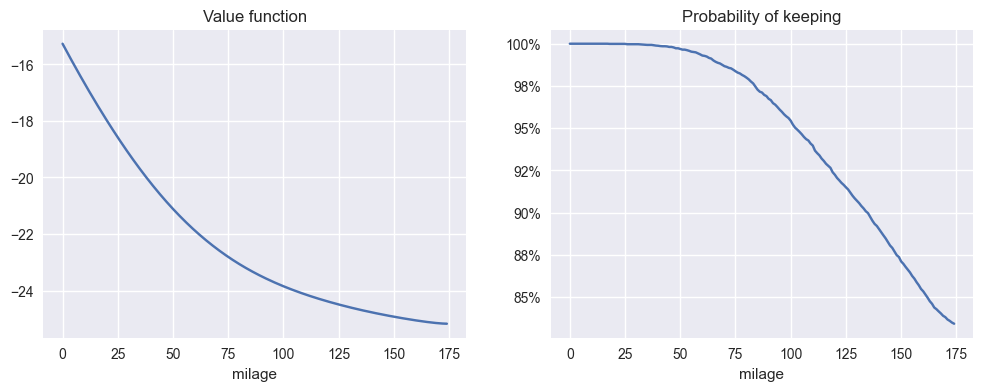

In [10]:
plot_solution(par, sol)

##### c) Why did the policy function change shape?

#### d) If we were to add more choices, what would the computational (speed) cost be? Why?

#### e) (Optional) Try to change the value of the scale parameter in the extreme-value distribution(sigma_eps in the code). What happens to the policy functions as the scale parameter goes to 0 or becomes very large? Set this back to 1.0 before proceeding. 

## Exercise 4: Taste Shocks (Analytic Extreme Value)

In the previous exercise we used Monte Carlo simulation to integrate out the taste shocks. In this exercise, we will use some powerful properties of the extreme value distribution to analytically solve for the expected value.

*Hint*: Find the closed form solution of the expected value and choice probability in the lecture slides.

##### a) Fill in the missing stuff in the *bellman* function under *taste_shocks == 'Extreme Value'*. Solve the model and plot the solution.

In [11]:
sol = model.solve_SA(par, stochastic_transition = True, taste_shocks = 'Extreme Value')

Finished after 1681 iterations
Convergence achieved: True


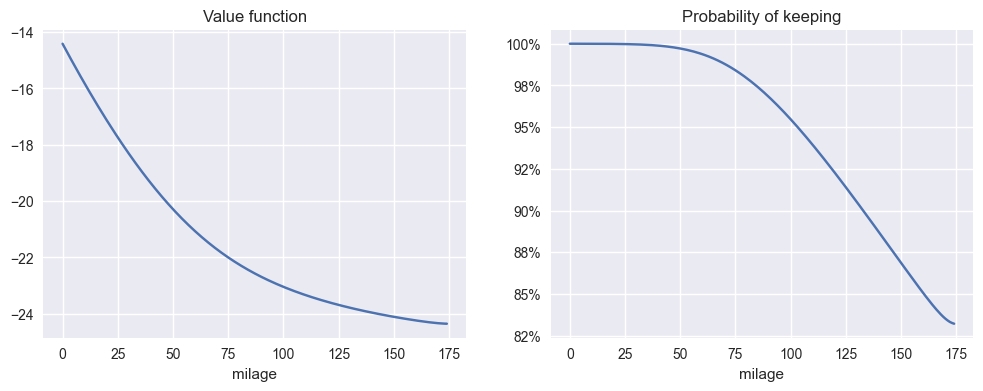

In [12]:
plot_solution(par, sol)

##### b) Are the solutions the same as with Monte Carlo? Why, why not?

## Exercise 5 - Taste shocks (Normally distributed)

Now lets change the distributional assumption of the taste shocks. Let us now assume that the taste shocks are standard normally distributed.

##### a) Fill in the missing stuff under *taste_shocks == 'Normal'*. Solve the model. Plot the solution.
*Hint*: Is there an analytical solution?

In [13]:
sol = model.solve_SA(par, stochastic_transition = True, taste_shocks = 'Normal')

Finished after 1678 iterations
Convergence achieved: True


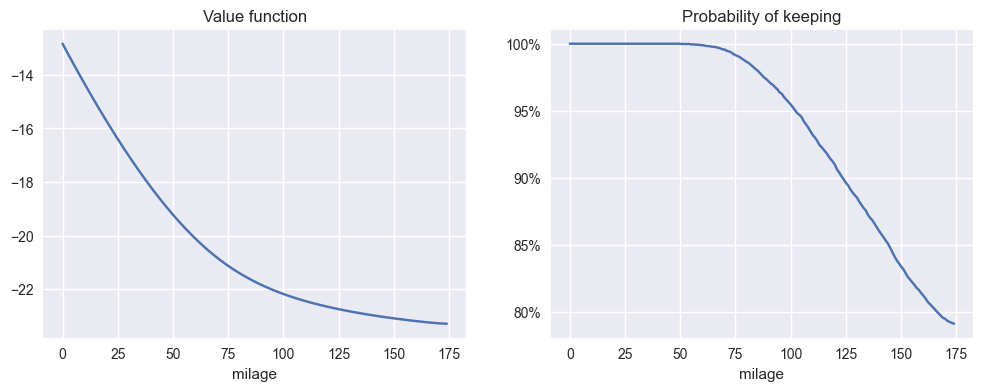

In [14]:
plot_solution(par, sol)

##### b) What is the advantage of assuming Extreme Value Type 1 taste shocks?

## (Optional) Exercise 6 - Vectorized 

##### a) Solve the model in a vectorized form by filling out the missing stuff in the *bellman_vectorized* function. Plot the solution.

Assume that there are Extreme Value shocks and a stochastic state transition. You have been given the state transition matrices, which you will have to use.

In [15]:
sol = model.solve_SA(par, vectorized = True)

Finished after 1681 iterations
Convergence achieved: True


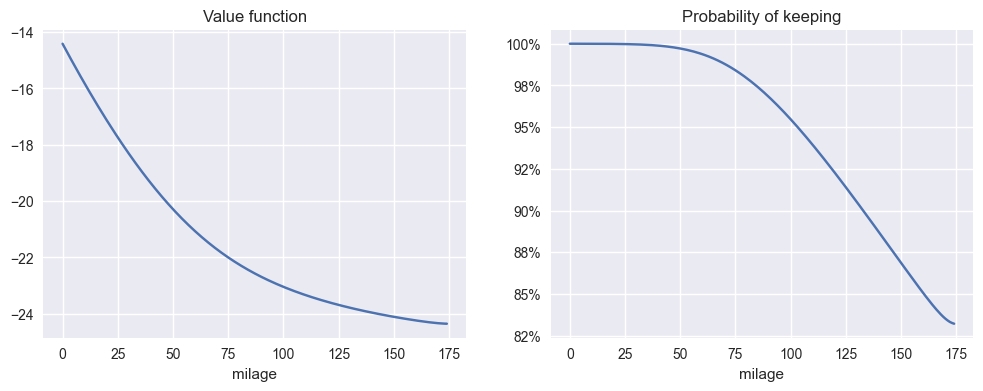

In [16]:
plot_solution(par, sol)

##### b) Are the results identical to the solution from exercise 4? What is the advantage of solving the model in a vectorized form?